# Exoplanet transit

In this tutorial we will reduce raw images to produce a transit light curve of WAPS-12 b. All images can be downloaded from [https://astrodennis.com/](https://astrodennis.com/).

## Managing the FITS

For this observation, the headers of the calibration images do not contain information about the nature of each image, bias, dark or flat. We will then retrieve our images by hand (where usually we would employ a [FitsManager](prose.FitsManager) object) 

In [1]:
from glob import glob

darks = glob("/Users/lgrcia/data/WASP12-astrodennis/Darks/*.fit")
bias = glob("/Users/lgrcia/data/WASP12-astrodennis/Bias/*.fit")
flats = glob("/Users/lgrcia/data/WASP12-astrodennis/Flats/*.fit")
sciences = sorted(glob("/Users/lgrcia/data/WASP12-astrodennis/ScienceImages/*.fit"))

## The full reduction

wWhat follows is the full reduction sequences, including the selection of a reference image to align sources and scale apertures on. More details are provided in the basic [Photometry](./photometry.ipynb) tutorial

In [2]:
import numpy as np
from prose import FITSImage, Sequence, blocks

# reference is middle image
ref = FITSImage(sciences[len(sciences)//2])

calibration = Sequence([
    blocks.Calibration(darks=darks, bias=bias, flats=flats),
    blocks.Trim(),
    blocks.PointSourceDetection(n=20), # stars detection
    blocks.Cutouts(21),                # stars cutouts
    blocks.MedianEPSF(),               # building EPSF
    blocks.psf.Moffat2D(),             # modeling EPSF
])

calibration.run(ref, show_progress=False)
radii = np.linspace(0.2, 8, 30)
calibration[2].n = 15  # only 15 stars for alignment

photometry = Sequence([
    *calibration,                           # calibration
    blocks.AlignReferenceSources(ref),      # alignment
    blocks.CentroidQuadratic(),             # centroiding
    blocks.AperturePhotometry(radii=radii), # aperture photometry
    blocks.AnnulusBackground(),
    blocks.GetFluxes(data=["fwhm","keyword:AIRMASS"])]
)

photometry.run(sciences)

  0%|          | 0/336 [00:00<?, ?images/s]

## Differential photometry

Now that the photometry has been extracted, let's focus on our target and produce a differential light curve for it.

All fluxes have been saved in the [GetFluxes](prose.blocks.GetFluxes) block, in a [Fluxes](prose.Fluxes) object 

In [3]:
fluxes = photometry[-1].fluxes

We can check the reference image, on which all images sources have been aligned, and pick our target

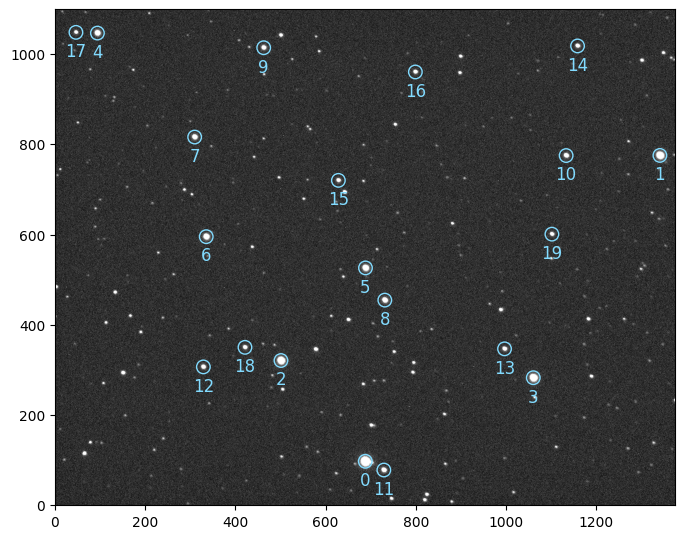

In [4]:
ref.show()

set this target (source `6`) in the [Fluxes](prose.Fluxes) object and proceed with automatic differential photometry

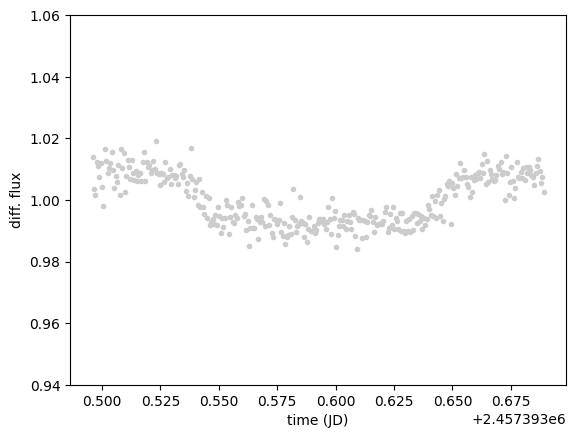

In [5]:
import matplotlib.pyplot as plt

fluxes.target = 6
diff = fluxes.autodiff()

# plotting
ax = plt.subplot(xlabel="time (JD)", ylabel="diff. flux", ylim=(0.94, 1.06))
diff.plot()

And here is our planetary transit. To help modeling the light curve, some explanatory measurements have been stored in

In [6]:
diff.dataframe

,bkg,fwhm,airmass,time,flux
0,267.465079,4.846805,1.878414,2.457393e+06,1.014062
1,268.262356,4.537788,1.870291,2.457393e+06,1.003489
2,266.142019,4.398865,1.862163,2.457393e+06,1.001689
3,257.600812,4.710428,1.854302,2.457393e+06,1.012300
4,257.840151,4.741433,1.846374,2.457393e+06,1.011143
...,...,...,...,...,...
331,161.812546,4.131535,1.013443,2.457394e+06,1.013144
332,162.039715,4.057126,1.013356,2.457394e+06,1.009250
333,160.809891,4.491863,1.013278,2.457394e+06,1.005487
334,160.646755,4.548293,1.013210,2.457394e+06,1.007344
